In [13]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input


import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
data = pd.read_csv('emails.csv')
data.head()


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [26]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [31]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


In [32]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


In [33]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           809312    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_36 (Dense)            (None, 32)                544       
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 813025 (3.10 MB)
Trainable params: 813025 (3.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [36]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [39]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
69/69 [==============================] - 3s 49ms/step - loss: 0.2073 - accuracy: 0.9717 - val_loss: 0.1472 - val_accuracy: 0.9708 - lr: 5.0000e-04
Epoch 2/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0898 - accuracy: 0.9867 - val_loss: 0.1137 - val_accuracy: 0.9745 - lr: 5.0000e-04
Epoch 3/20
69/69 [==============================] - 3s 46ms/step - loss: 0.0566 - accuracy: 0.9913 - val_loss: 0.1191 - val_accuracy: 0.9690 - lr: 5.0000e-04
Epoch 4/20
69/69 [==============================] - 4s 63ms/step - loss: 0.0409 - accuracy: 0.9941 - val_loss: 0.1402 - val_accuracy: 0.9672 - lr: 5.0000e-04
Epoch 5/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0263 - accuracy: 0.9968 - val_loss: 0.1181 - val_accuracy: 0.9745 - lr: 2.5000e-04


In [38]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


18/18 [==============================] - 0s 10ms/step - loss: 0.2989 - accuracy: 0.9635
Test Loss : 0.29891178011894226
Test Accuracy : 0.9635036587715149


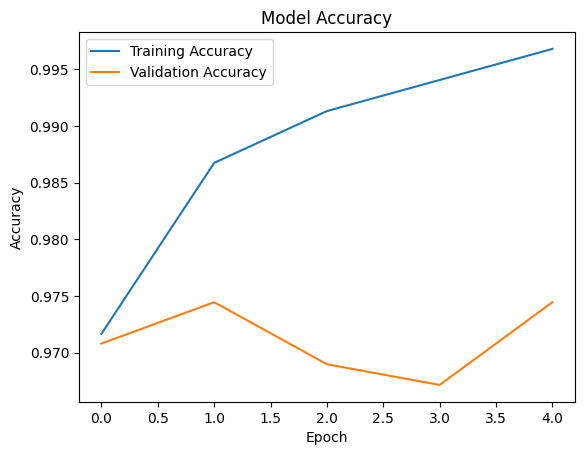

In [40]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


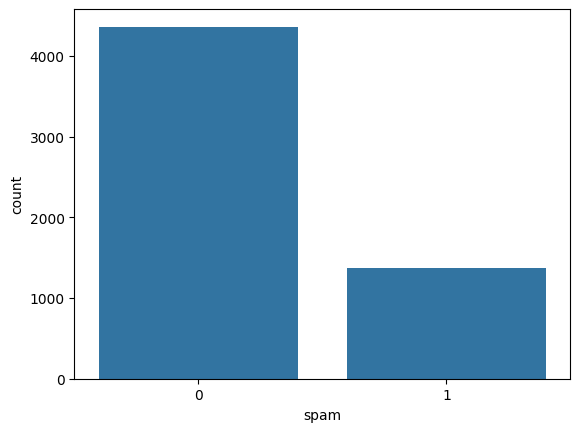

In [24]:
sns.countplot(x='spam', data=data)
plt.show()


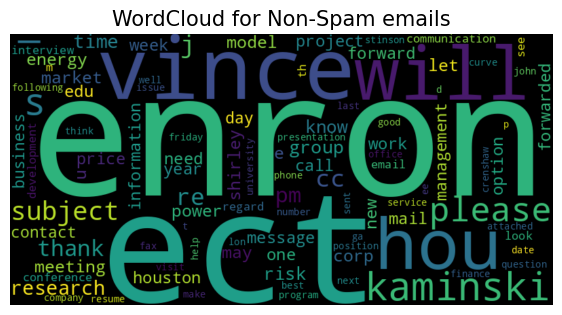

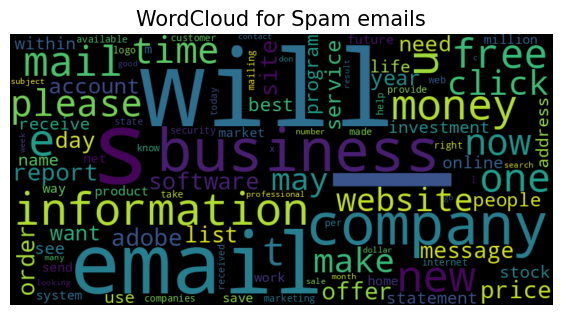

In [27]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


1/1 [==============================] - 0s 200ms/step
Epoch: 0, Discriminator Loss: [0.6919627785682678, 0.0], Generator Loss: 0.6875922679901123
1/1 [==============================] - 0s 19ms/step


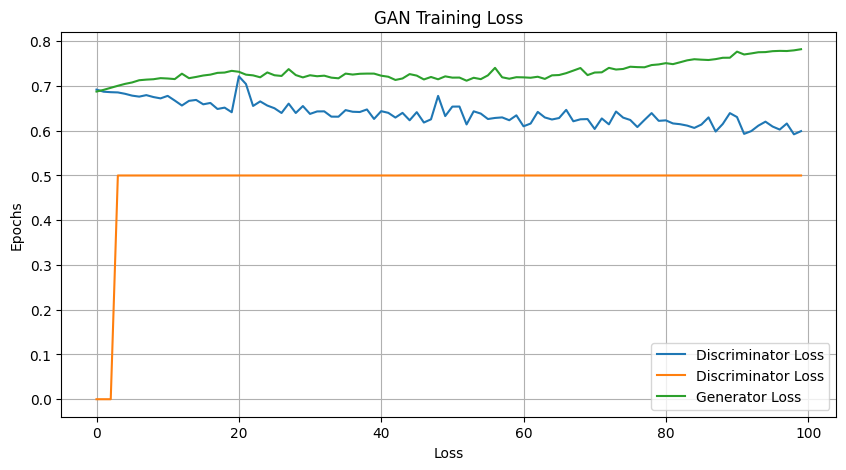

In [28]:
# Preprocess the data
X = data['text']
y = data['spam']

# Convert text to numerical data (you can use techniques like TF-IDF or word embeddings)
# For simplicity, let's just use the length of the text
X = X.apply(lambda x: len(x))

# Standardize the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the generator model
generator = Sequential([
    Dense(128, input_dim=1),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Define the discriminator model
discriminator = Sequential([
    Dense(128, input_dim=1),
    LeakyReLU(alpha=0.2),
    Dense(64),
    LeakyReLU(alpha=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Compile the generator
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Define the GAN model
discriminator.trainable = False
gan_input = Input(shape=(1,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train the GAN
def train_gan(generator, discriminator, gan, X_train, batch_size, epochs):
    d_loss = []
    g_loss = []

    for epoch in range(epochs):
        noise = np.random.normal(0, 1, size=[batch_size, 1])
        fake_data = generator.predict(noise)
        real_data = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

        X_batch = np.concatenate([real_data, fake_data])
        y_discriminator = np.zeros(2 * batch_size)
        y_discriminator[:batch_size] = 0.9  # Label smoothing

        discriminator.trainable = True
        d_loss.append(discriminator.train_on_batch(X_batch, y_discriminator))

        noise = np.random.normal(0, 1, size=[batch_size, 1])
        y_generator = np.ones(batch_size)
        discriminator.trainable = False
        g_loss.append(gan.train_on_batch(noise, y_generator))

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Discriminator Loss: {d_loss[-1]}, Generator Loss: {g_loss[-1]}")

    return d_loss, g_loss
def plot_loss(d_loss, g_loss):
    plt.figure(figsize= (10 , 5))
    plt.plot(d_loss, label='Discriminator Loss')
    plt.plot(g_loss, label='Generator Loss')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Set up hyperparameters
epochs = 100
batch_size = 32

# Train the GAN
d_loss, g_loss = train_gan(generator, discriminator, gan, X_train, batch_size, epochs)

# Plot the loss
plot_loss(d_loss, g_loss)


